In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
image_size = (140, 140)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 3270 files belonging to 2 classes.
Using 2616 files for training.
Found 3270 files belonging to 2 classes.
Using 654 files for validation.


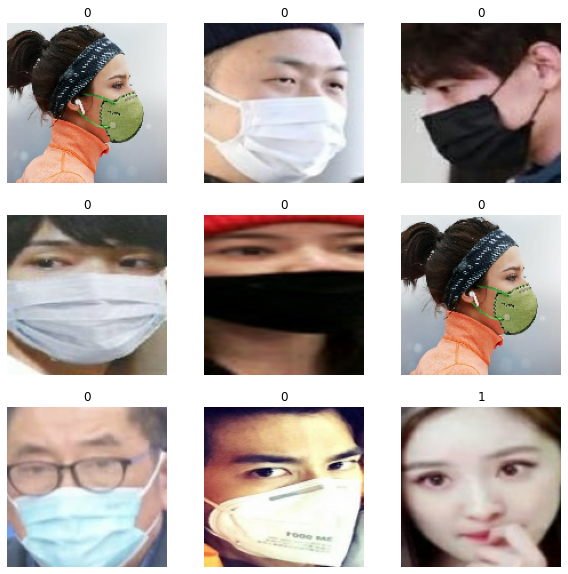

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

plt.savefig('data_example.jpg', dpi=500)


In [4]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

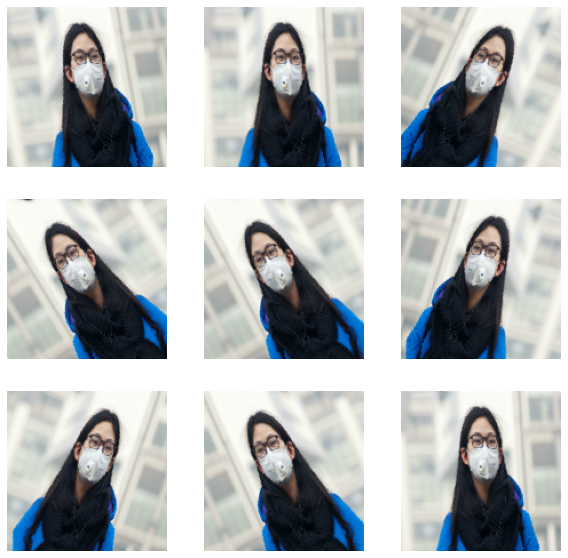

In [5]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

plt.savefig('augmentation_example.jpg', dpi=500)


In [6]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


In [7]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [8]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/50
82/82 [==============================] - ETA: 0s - loss: 0.3474 - accuracy: 0.8647

C:\Users\olsen\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


82/82 [==============================] - 28s 246ms/step - loss: 0.3474 - accuracy: 0.8647 - val_loss: 0.6901 - val_accuracy: 0.5275
Epoch 2/50
82/82 [==============================] - 17s 207ms/step - loss: 0.2311 - accuracy: 0.9151 - val_loss: 0.6878 - val_accuracy: 0.5275
Epoch 3/50
82/82 [==============================] - 16s 191ms/step - loss: 0.2025 - accuracy: 0.9209 - val_loss: 0.6820 - val_accuracy: 0.5275
Epoch 4/50
82/82 [==============================] - 13s 161ms/step - loss: 0.1912 - accuracy: 0.9297 - val_loss: 0.6211 - val_accuracy: 0.6116
Epoch 5/50
82/82 [==============================] - 14s 168ms/step - loss: 0.1462 - accuracy: 0.9434 - val_loss: 0.6100 - val_accuracy: 0.5413
Epoch 6/50
82/82 [==============================] - 12s 144ms/step - loss: 0.1479 - accuracy: 0.9450 - val_loss: 0.2469 - val_accuracy: 0.9098
Epoch 7/50
82/82 [==============================] - 12s 145ms/step - loss: 0.1189 - accuracy: 0.9587 - val_loss: 0.1411 - val_accuracy: 0.9541
Epoch 8/50

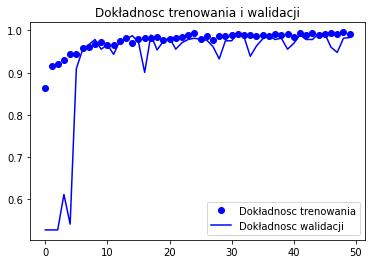

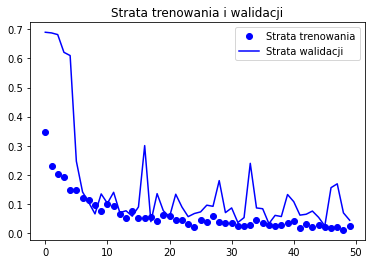

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Dokładnosc trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokładnosc walidacji')
plt.title('Dokładnosc trenowania i walidacji')
plt.legend()

plt.savefig('dokladnosc_trenowania_i_walidacji.jpg', dpi=500)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.savefig('straty_trenowania_i_walidacji.jpg', dpi=500)
plt.show()

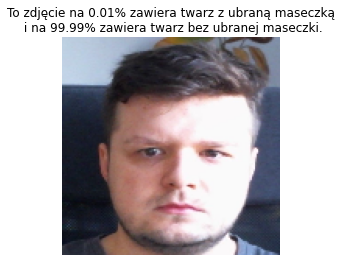

In [10]:
img = keras.preprocessing.image.load_img(
    "test_images/without_mask.png", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]

plt.imshow(img)
plt.title("To zdjęcie na %.2f%% zawiera twarz z ubraną maseczką\n i na %.2f%% zawiera twarz bez ubranej maseczki." % (100 * (1 - score), 100 * score))
plt.axis("off")

plt.savefig('prediction_without_mask.jpg', dpi=500)


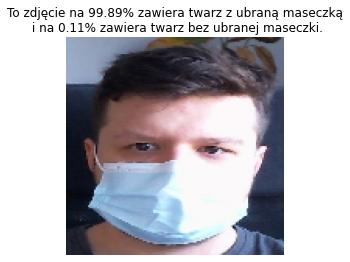

In [11]:
img = keras.preprocessing.image.load_img(
    "test_images/with_mask.png", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]

plt.imshow(img)
plt.title("To zdjęcie na %.2f%% zawiera twarz z ubraną maseczką\n i na %.2f%% zawiera twarz bez ubranej maseczki." % (100 * (1 - score), 100 * score))
plt.axis("off")

plt.savefig('prediction_with_mask.jpg', dpi=500)

In [12]:
model.save('saved_model.h5')